# Simple Galaxy Model

In [43]:
# basics
import numpy as np
# from scipy import stats
# import pandas as pd
# import datetime

# astronomy
from astropy import units as u
from astropy.cosmology import Planck18 as cosmo
from astropy.cosmology import z_at_value
# from astropy.table import Table, join
# from astropy.io import fits

# plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.cm as cm

#  TO ASK

- is the correct term for $$\frac{m_{star}}{m_{gas}}$$ gas mass fraction or stellar mass fraction? I'm confused at the moment, since gas mass fraction could also mean $$\frac{m_{gas}}{m_{gas} + m_{star}}$$ . Or would stellar mass fraction be $$\frac{m_{star}}{m_{gas} + m_{star}}$$ instead?

In [48]:
class Environment:
    """Class for simple environment of one or more galaxies of the Galaxies 
    class.
    
    Attributes
    ----------
    age : float, optional
        The current age of the system in Gyrs (default 0.)
    galaxies : list, optional
        List of all Galaxy objects in this environment (default None)
    gas : float, optional
        The amount of gas available in the environment (default np.inf)
    lookbacktime : float, optional
        The current cosmic lookback time (default None)
    name : str, optional
        The name of the galaxy (default 'Test_Env')
    zcurrent : float, optional
        The current redshift of the system (default None)
    zstart : float, optional
        The initial redshift of the system (default 6.)

    Methods
    -------
    create_Galaxy(galaxy_kwargs: dict = None)
        Creates Galaxy object and adds it to galaxies list
    evolve(timestep: float = 1.)
        Evolves the environment and all galaxies in it by one timestep
    naive_evolve(timestep: float = 1.)
        Naively evolves the environment and all galaxies in it by one timestep
    reference_evolve(timestep: float = 1.e-3)
        Evolves the environment and all galaxies acc. to Lilly+13, Eq.12a,13a,14a
    """
    
    def __init__(self, 
                 age: float = 0.,
                 galaxies: list = None,
                 gas: float = np.inf, 
                 lookbacktime: float = None,
                 name: str = 'Test_Env', 
                 zstart: float = 6.
                ):
        self.age = age
        self.galaxies =  galaxies if galaxies else []
        self.gas = gas
        self.lookbacktime = lookbacktime
        self.name = name
        self.zstart = zstart
        
        # make either lookbacktime from zstart or vice versa
        # zstart --> lookbacktime
        if (lookbacktime is None) and (zstart is not None):
            self.lookbacktime = cosmo.lookback_time(zstart)  # IMPLICIT HARDCODING OF Gyr from astropy routine!
        # lookbacktime --> zstart
        elif (zstart is None) and (lookbacktime is not None):
            self.zstart = z_at_value(cosmo.age, lookbacktime * u.Gyr)  # UNIT Gyr HARDCODED!!
        else: 
            # neither supplied --> default zstart=6
            if (zstart is None) and (lookbacktime is None):
                print(f"Neither intial redshift nor lookback time are supplied!\n" + 
                      f"Reverting back to default value of z=6 and corresponding\n" + 
                      f"lookback time calculated from it.")
                self.zstart = 6.  # EXPLICIT HARD-CODING OF DEFAULT z=6
            # both supplied --> use zstart --> lookbacktime
            elif (zstart is not None) and (lookbacktime is not None):
                print(f"Both intial redshift and lookback time are supplied!\n" + 
                      f"Will use the supllied value of z={zstart:9.2f} to calculate\n" + 
                      f"the corresponding lookback time from it.")
            self.lookbacktime = cosmo.lookback_time(self.zstart)  # IMPLICIT HARDCODING OF Gyr from astropy routine!
        
        # compute zcurrent from self.zstart
        self.zcurrent = self.zstart
        return
        
    def create_Galaxy(self, 
                      **galaxy_kwargs: dict
                     ):
        gal = Galaxy(env=self, **galaxy_kwargs)
        self.galaxies.append(gal)
        return gal
        
    
    def evolve(self, 
               timestep: float = 1.
              ):
        for gal in self.galaxies:
            gal.evolve(timestep=timestep)
        return
    
    
    def naive_evolve(self, 
                     timestep: float = 1.e-3
                    ):
        for gal in self.galaxies:
            gal.naive_evolve(timestep=timestep)
        return
    
    
    def reference_evolve(self, 
                         timestep: float = 1.
                        ):
        # make the time step in lookbacktime, then convert to z as well
        self.env.lookbacktime -= timestep
        self.env.zcurrent = z_at_value(cosmo.age, self.env.lookbacktime * u.Gyr)  # Gyr HARDCODED AGAIN!
        
        # go through all the galaxies and evolve/update them based on new time
        for gal in self.galaxies:
            gal.reference_evolve(timestep=timestep)
        return





class Galaxy:
    """Class for simple model of a galaxy. Every galaxy should be associated
    with exactly one Environment object, which provides a method to create
    a galaxy and add it to its galaxy list.
    
    Attributes
    ----------
    env : Environment
        The environment object the galaxy is associated with/located in
    accretionrate : float, optional
        The accretion rate of galaxy (default 0.)
    gas : float, optional
        The gas mass content of the galaxy (default 0.)
    gasmassfraction : float, optional
        The ratio of gas mass to stellar mass (default 1.)
    GCR : float, optional
        The change rate ∂/∂t in gas mass content of the galaxy (default 0.)
    instantreturnfraction: float, optional
        The fraction of gas being converted to stars that is promptly, 
        here instantly, returned to the gas reservoir (default 0.4) 
    massloadingfactor : float, optional
        The mass-loading factor coupling SFR and mass loss (default 0.)
    massloss : float, optional
        The mass loss from the galaxy (defaul 0.)
    masslost: float, optional
        The mass lost from the system due to massloss (default 0.)
    name : str, optional
        The name of the galaxy (default 'Test_Gal')
    outflowrate : float, optional
        SHOULD BE DEPRECATED - REDUNDANT TO self.massloss!! REPLACE!!
        The outflow rate of the galaxy
    rsSFR : float, optional
        The reduced specific SFR; excludes instant.returned gas (default 0.)
    SFefficiency : float, optional
        The star formation efficiency (default 1.)
    SFR : float, optional
        The star formation rate in the galaxy (default 0.)
    SNfeedback : float, optional
        The supernova feedback in the galaxy (default 0.)
    sSFR: float, optional
        The actual specific star formation rate; this sSFR does not account
        for reduction by the inst. return to the gas reservoir (default 0.)
    stars : float, optional
        The stellar mass content of the galaxy (default 0.)
    
    Methods
    -------
    kick(timestep: float = 1.)
        The 'kick' of leapfrog kdk integration for this galaxy
    drift(timestep: float = 1.)
        The 'drift' of leapfrog kdk integration for this galaxy
    evolve(timestep: float = 1.)
        Evolves this galaxy by one timestep
    """
    
    def __init__(self, 
                 env: Environment, 
                 accretionrate: float =0., 
                 gas: float = 0.,
                 gasmassfraction: float = 1.,
                 GCR: float = 0.,
                 instantreturnfraction: float = 0.4, 
                 massloadingfactor: float = 0., 
                 massloss: float = 0., 
                 masslost: float = 0., 
                 name: str ='Test_Gal', 
                 outflowrate: float = 0., 
                 rsSFR: float = 0., 
                 SFefficiency: float = 1., 
                 SFR: float = 0., 
                 SNfeedback: float = 0., 
                 sSFR: float = 0., 
                 stars: float = 0.
                ):
        self.env = env
        self.accretionrate = accretionrate
        self.gas = gas
        self.gasmassfraction = gasmassfraction
        self.GCR = GCR
        self.instantreturnfraction = instantreturnfraction
        self.massloadingfactor = massloadingfactor
        self.massloss = massloss
        self.masslost = masslost
        self.name = name
        self.outflowrate = outflowrate
        self.rsSFR = rsSFR
        self.SFefficiency = SFefficiency
        self.SFR = SFR
        self.SNfeedback = SNfeedback
        self.sSFR = sSFR
        self.stars = stars
        
    
    # ------------------------------
    # time integration of the system
    # THIS USES A DUMMY SYSTEM!
    
    def kick(self, 
             timestep: float = 1.
            ):
        """The 'kick' of leapfrog kdk integration for this galaxy"""
        self.accretionrate += 0. * (timestep / 2.)   # still constant for now
        self.outflowrate += 0. * (timestep / 2.)  # still constant for now
        return
    
    def drift(self, 
              timestep: float = 1.
             ):
        """The 'drift' of leapfrog kdk integration for this galaxy"""
        # compute accreted and expelled gas
        gas_accreted = self.accretionrate * timestep
        if gas_accreted > self.env.gas:
            gas_accreted = self.env.gas
        gas_expelled = self.outflowrate * timestep
        if gas_expelled > self.gas:
            gas_expelled = self.gas
        # update gas in environment
        self.env.gas -= (gas_accreted - gas_expelled)       
        # update galaxy gas content
        self.gas += (gas_accreted - gas_expelled)
        return
    
    def evolve(self, 
               timestep: float = 1.
              ):
        """Evolves this galaxy by one timestep, inspired by leapfrog k-d-k"""
        # -----------------------------------------
        # kick: updating accretion and outflow rate
        self.kick(timestep)
        
        # ------------------------------------------------
        # drift: updating gas contents both in gal and env
        self.drift(timestep)
        
        # ------------------------------
        # kick: updating accretion again
        self.kick(timestep)
        
        return
    
    
    # --------------------------------------------------
    # This is a naive implementation of the kdk leapfrog
    
    
    # The kick DOES NOT depend on the time step - this is a problem!
    def naive_kick(self, 
                   timestep: float = 1.
                  ):
        """Naive version of the 'kick' of leapfrog kdk integration for this galaxy"""
        self.SFR = self.SFefficiency * self.gas
        self.GCR = self.accretionrate - (1. - self.instantreturnfraction + self.massloadingfactor) * self.SFR
        self.massloss = self.massloadingfactor * self.SFR
        return
    
    
    # The drift is reasonable, I think!
    def naive_drift(self, 
                    timestep: float = 1.
                   ):
        """Naive version of the 'drift' of leapfrog kdk integration for this galaxy"""
        self.stars = self.stars + self.SFR * timestep
        self.gas = self.gas + self.GCR * timestep
        self.masslost = self.masslost + self.massloss * timestep
        return
    
    
    def naive_evolve(self, 
                     timestep: float = 1.
                    ):
        """Naively evolves this galaxy by one timestep, simply and probably involuntarily Eulerian"""
        self.naive_kick(timestep/2.)
        self.naive_drift(timestep)
        self.naive_kick(timestep/2.)
        return

    
    
    
    # ---------------
    # This is the reference model from Lilly et al. 2013, ideal case
    # based on Eqn. (12a), (13a), (14a)
    # fractional splitting of incoming baryons, cf.Lilly+13,Eqns. 12-14a
        
    def compute_fstar(self):
        """Fraction of incomming gas converted to stars,
        based on Eq. 12a from Lilly+13, for ideal regulator"""
        _tmp = (1. 
                + self.massloadingfactor/(1. - self.instantreturnfraction) 
                + self.sSFR/self.SFefficiency)
        return 1./_tmp
    
    def compute_fout(self):
        """Fraction of incomming gas expelled again from the galaxy,
        based on Eq. 13a from Lilly+13, for ideal regulator"""
        _tmp = (1. 
                + self.massloadingfactor/(1. - self.instantreturnfraction) 
                + self.sSFR/self.SFefficiency)
        return (self.massloadingfactor/(1. - self.instantreturnfraction))/_tmp 
    
    def compute_fres(self):
        """Fraction of incomming gas added to the galaxy gas reservoir,
        based on Eq. 14a from Lilly+13, for ideal regulator"""
        _tmp = (1. 
                + self.massloadingfactor/(1. - self.instantreturnfraction) 
                + self.sSFR/self.SFefficiency)
        return (self.sSFR/self.SFefficiency)/_tmp
    
    def reference_evolve(self, 
                         timestep: float = 1.
                        ):
        
        # update the time-variable quantities involved, in this case sSFR
        update_rsSFR(mstar=self.stars, 
                     z=self.env.zcurrent
                    )
        update_sSFR(rsSFR=self.rsSFR, 
                    returnfraction=self.instantreturnfraction
                   )
        
        fstar = compute_fstar()
        fout = compute_fout()
        fres = compute_fres()
        
        # ==========================
        # 
        # W O R K   H E R E ! ! !  (essentially Figure 2 from Lilly+13)
        # 
        # ==========================
        
        # update stellar mass, gas mass and ejected mass
        # DO NOT USE THE EXISTING ROUTINES, they are from another version/design!!!
        
        # updating the change rates for stars, outflows and gas reservoir
        self.SFR = fstar * self.accretionrate
        self.massloss = fout * self.accretionrate
        self.GCR = fres * self.accretionrate
        
        # computing new values of mass of stars, lost and gas reservoir
        self.stars += self.SFR * timestep
        self.masslost += self.massloss * timestep
        self.gas += self.GCR * timestep
        
        return
    
    
    # --------------------
    # UNCLEAR FUNCTION!!!!
    
    def dlnGMFoverdt(self):
        """This method will need to compute the change of 
        ln(gasmassfraction) with time"""
        return
        
        # IDEA: crude linear computation would be:
        # d GMF / dt (i) = ( gasmassfraction(i) - gasmassfraction(i-1) ) / timestep
        # same for ln(GMF)m, just take ln of each GMF
        # CAVEAT: Does this violate leapfrog? Or maybe this is exactly the usecase?
    
    
    # -------------------------------------------------------------------
    # Functions for physical parameters that might also not change at all
    
    # Use with different values e.g. for SFE(mstar,t), mass loading fact(mgas,t)
    def Parameter_function(self, quant, t, quant0, t0, a1, a2, a3):
        """Some arbitrary function e.g. for star formation efficiency of form:
        offset + amplitude * (quant/quant_norm)**(factor * t/t_norm).
        Units: [1/time] + [1] * ([quant] / [quant])**([1] * [time] / [time])"""
        return a3 + a2 * ((qaunt/quant0)**(a1 * t/t0))
    
    # ∂ Parameter(Quantity,t) / ∂ t
    def pdv_Parameter_t_function(self, quant, t, quant0, t0, a1, a2, a3):
        """Partial derivative w.r.t. time t of the arbitrary function above"""
        return ((a1/t0) * np.log(quant/quant0) * 
                (SFE_function(quant, t, quant0, t0, a1, a2, a3) - a3))
    
    # ∂ Parameter(Quantity,t) / ∂ Quantity
    def pdv_Parameter_Quantity_function(self, quant, t, quant0, t0, a1, a2, a3):
        """Partial derivative w.r.t. the quantity of the arbitrary function above"""
        return ((a1*t)/(t0*quant) * 
                (SFE_function(quant, t, quant0, t0, a1, a2, a3) - a3))
        
    
    
    
    # ---------------------------------------------------------
    # mstar, mgas, mexp and their 1st and 2nd order derivatives
    
    # mstar
    def update_mstar(self, *args, **kwargs):
        """Calls up update_mstar and uses it"""
        return update_stars
    
    def update_mstardot(self, *args, **kwargs):
        """Straightforward, calls the respective SFR update method"""
        return update_SFR(*args, **kwargs)
    
    def update_mstardotdot(self, *args, **kwargs):
        return # TODO -> HERE !!!
    
    
    # mgas
    def update_mgas(self, *args, **kwargs):
        return
    
    def update_mgasdot(self, *args, **kwargs):
        return
    
    def update_mgasdotdot(self, *args, **kwargs):
        return
    
    
    # mexp
    def update_mexp(self, *args, **kwargs):
        return
    
    def update_mexpdot(self, *args, **kwargs):
        return
    
    def update_mexpdotdot(self, *args, **kwargs):
        return
    
    
    
    # ------------------------------------------
    # computing and updating physical quantities
    
    
    # gasmassfraction
    def update_gasmassfraction(self, *args, **kwargs):
        self.gasmassfraction = self.compute_gasmassfraction(*args, **kwargs)
        return self.gasmassfraction
    
    def compute_gasmassfraction(self, 
                                SFefficiency: float, 
                                sSFR: float, 
                                kappa: float = None, 
                                mstar: float = None
                               ):
        """Compute the gas mass fraction according to Lilly et al. 2013,
        Eqns. (7) and (7a)"""
        gmf = sSFR / SFefficiency
        if (kappa is not None) and (mstar is not None):
            # this is Eq. (7a) ; with more information and dep. on mstar
            exp1 = 1. / kappa
            exp2 = - (kappa - 1.) / kappa
            return gmf**exp1 * mstar**exp2
        else:
            # this is Eq. (7) ; the simplified case
            return gmf
    
    
    # massloss
    def update_massloss(self, *args, **kwargs):
        self.massloss = self.compute_massloss(*args, **kwargs)
        return self.massloss
    
    def compute_massloss(self, 
                         massloadfact: float, 
                         SFR: float
                        ):
        """Compute the mass loss accordings to Lilly et al. 2013,
        Eq. (8)"""
        return massloadfact * SFR    
    
    
    # rsSFR
    def update_rsSFR(self, *args, **kwargs):
        self.rsSFR = self.compute_rsSFR(*args, **kwargs)
        return self.rsSFR
    
    def compute_rsSFR(self, 
                      mstar: float, 
                      z: float
                     ):
        """Computes the reduced specific star formation rate according to
        Lilly et al. 2013, Eq. (2), for z < 2. and z > 2., respectively"""
        if z < 2.:
            return 0.07 * (10**10.5 / mstar)**(0.1) * (1 + z)**3 * 10**(-9)
        else:
            return 0.3 * (10**10.5 / mstar)**(0.1) * (1 + z)**(5/3) * 10**(-9)
    
    
    # SFefficiency
    def update_SFefficiency(self, *args, **kwargs):
        self.SFefficiency = compute_SFefficiency(*args, **kwargs)
        return self.SFefficiency
    
    def compute_SFefficiency(self, 
                             *SFEfunc_args: list, 
                             SFEfunc: callable = None, 
                             isconst: bool = True
                            ):
        # if isconst=False but no function: use def. exp. func. with min. 2 args
        if ((not isconst) and (SFEfunc is None)):
            Nargs = len(SFEfunc_args)
            if (Nargs < 2) or (Nargs > 4):
                fewmany = 'few' if Nargs < 2 else 'many'
                print(f"Too {fewmany} function arguments for default function:\n" + 
                      "SFE = x3 + x2 * x0**x1\n" + 
                      "with x0,x1,x2,x3 = *SFEfunc_args and x2,x3 optional.\n" + 
                      "Returning CONSTANT value for SFE instead!")
                SFEfunc = lambda x0: x0
                SFEfunc_args = [self.SFefficiency]
            elif Nargs == 2:
                SFEfunc = lambda x0, x1: x0**x1
            elif Nargs == 3:
                SFEfunc = lambda x0, x1, x2: x2*(x0**x1)
            elif Nargs == 4:
                SFEfunc = lambda x0, x1, x2, x3: x3 + (x2 * (x0**x1))
            else:
                print("I don't know where you got here - \n" + 
                      "please report as a bug to me!")
            return SFEfunc(*SFEfunc_args)
        # if isconst=False and a function is provided: use func and args
        elif ((not isconst) and 
              (SFEfunc is not None)):
            return SFEfunc(*SFEfunc_args)
        else:
            # if nothing is provided: const. SFE
            return self.SFefficiency
    
    
    # SFR
    def update_SFR(self, *args, **kwargs):
        self.SFR = self.compute_SFR(*args, **kwargs)
        return self.SFR
    
    def compute_SFR(self, 
                    SFefficiency: float, 
                    mgas: float
                   ):
        """Computes the star formation rate according to 
        Lilly et al. 2013, Eq. (4)"""
        return SFefficiency * mgas
    
    
    # sSFR
    def update_sSFR(self, *args, **kwargs):
        self.sSFR = self.compute_sSFR(*args, **kwargs)
        return self.sSFR
    
    def compute_sSFR(self, 
                     rsSFR: float, 
                     returnfraction: float
                    ):
        """Computes the actual, unreduced SFR from the rsSFR"""
        return rsSFR / (1. - returnfraction)
    
    
    # stars
    def update_stars(self, *args, **kwargs):
        self.stars = self.compute_stars(*args, **kwargs)
        return self.stars
    
    def compute_stars(self, 
                      mstar: float, 
                      SFR: float, 
                      timestep: float
                     ):
        """Computes new stellar mass based on prev. mstar and the SFR"""
        return mstar + (SFR * timestep)
    
    


#### Test length of string to keep standards

In [49]:
len("Some function for star formation efficiency, no idea wif this makes sense")

73

#### Current test: use NAIVE leapfrog kdk implementation

Since the results of the 2nd kick are not used before the 1st kick of the next timestep occurs, and since all kick quantities are computed NOT iteratively but purely from the results of the drift, the 2nd kick (CORRECTION: the 1st, half-step kick, since the 2nd kick at integer step gets printed to output) is at the moment obsolete. 

This would be different if:
(a) there was an iterative form of the kick, meaning each kick would build onto the previous one; analogous to v_1+1/2 = v_1 + a_1 * Δt/2
(b) if the masslodingfactor and SFefficiency weren't constant but time-dependent and would be updated in each kick, then we could use the mean values and of SFR, GCR and massloss for the drift step. Not sure if that would be more accurate, though, in the kdk formalism. It would probably introduce some kind of lag in SFR, GCR and massloss by approx. 1/4 Δt (in linear regime: halfway between two data points that are Δt/2 apart).

For the moment, though: naive implementation, which should basically be Eulerian. Quite the educational experience, though...

In [36]:
Env_A = Environment(name='Environment A', gas=np.inf)

In [37]:
Gal_A1 = Env_A.create_Galaxy(accretionrate=2.,
                             gas = 100.,
#                              gasmassfraction = 1.,
                             GCR = 2.,
                             instantreturnfraction = 0.4, 
                             massloadingfactor = 0.1, 
                             massloss = 1., 
                             masslost = 0., 
                             name = 'Galaxy A1', 
#                              outflowrate = 0., 
#                              rsSFR = 0., 
                             SFefficiency = 0.2, 
                             SFR = 5., 
#                              SNfeedback = 0., 
#                              sSFR = 0., 
                             stars = 10.
                            )

In [38]:
stars_results_list = []
gas_results_list = []
masslost_results_list = []

for t in range(100):
    Env_A.naive_evolve(1.)
    stars_results_list.append(Gal_A1.stars)
    gas_results_list.append(Gal_A1.gas)
    masslost_results_list.append(Gal_A1.masslost)

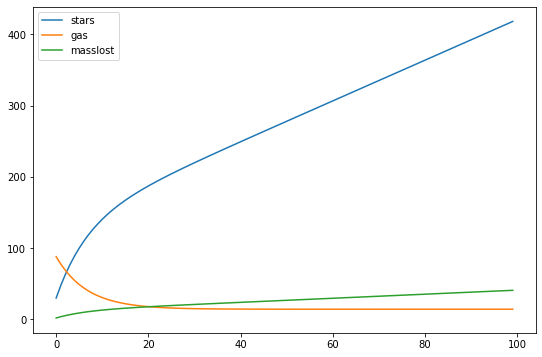

In [39]:
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(range(len(stars_results_list)), stars_results_list, label='stars')
ax.plot(range(len(gas_results_list)), gas_results_list, label='gas')
ax.plot(range(len(masslost_results_list)), masslost_results_list, label='masslost')
plt.legend()

#### Early toy model test

In [ ]:
a_env = Environment(name='Environment A', gas=1000.)

In [ ]:
a1_gal = a_env.create_Galaxy(name='Galaxy A1', 
                            gas=100.,
                            accretionrate=2., 
                            outflowrate=1.)

In [ ]:
print(a1_gal.name)
print(a1_gal.gas)
print(a_env.gas)

In [ ]:
a2_gal = a_env.create_Galaxy(name='Galaxy A2', 
                            gas=200.,
                            accretionrate=3., 
                            outflowrate=1.)

In [ ]:
a1_gal_gas_list = [a1_gal.gas]
a2_gal_gas_list = [a2_gal.gas]
a_env_gas_list = [a_env.gas]
for t in range(700):
    a_env.evolve(1.)
    a1_gal_gas_list.extend([a1_gal.gas])
    a2_gal_gas_list.extend([a2_gal.gas])
    a_env_gas_list.extend([a_env.gas])
a1_gal_gas_arr = np.asarray(a1_gal_gas_list)
a2_gal_gas_arr = np.asarray(a2_gal_gas_list)
a_env_gas_arr = np.asarray(a_env_gas_list)

In [ ]:
a1_gal_gas_arr

In [ ]:
a2_gal_gas_arr

In [ ]:
a_env_gas_arr

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(len(a1_gal_gas_arr)), a1_gal_gas_arr, label=a1_gal.name)
ax.plot(range(len(a2_gal_gas_arr)), a2_gal_gas_arr, label=a2_gal.name)
ax.plot(range(len(a_env_gas_arr)), a_env_gas_arr, label=a_env.name)
plt.legend()

In [ ]:
a_env = Environment(name='Environment A', gas=1000.)

In [ ]:
for igal in range(5):
    a_env.create_Galaxy(name=f'Galaxy A{igal}', 
                            gas=100. + 100. * igal,
                            accretionrate=10. - (2 * igal), 
                            outflowrate=2. + igal)

In [ ]:
gal_gas_list = [] 
for gal in a_env.galaxies:
    gal_gas_list.append([gal.gas])
env_gas_list = [a_env.gas]

for t in range(700):
    a_env.evolve(1.)
    for (gal, list_entry) in zip(a_env.galaxies, gal_gas_list):
        list_entry.extend([gal.gas])
    env_gas_list.extend([a_env.gas])

In [ ]:
fig, ax = plt.subplots(figsize=(9,6))
for (gal, gas_list) in zip(a_env.galaxies, gal_gas_list):
    ax.plot(range(len(gas_list)), np.array(gas_list), label=gal.name)
ax.plot(range(len(env_gas_list)), np.array(env_gas_list), label=a_env.name)
ax.set_xlabel('time')
ax.set_ylabel('gas mass')
plt.legend()

fig.savefig('plots_SGM/Simple_Galaxy_Model_test.pdf')